<a href="https://colab.research.google.com/github/rm-rf-humans/QNN/blob/main/H_QNNs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pennylane

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 39.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 930.0/930.0 kB 54.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 74.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 74.5 MB/s eta 0:00:00


In [102]:
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset, Subset
from PIL import Image
import os
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [103]:
class BreastCancerDataset(Dataset):
    def __init__(self, image_paths, transform=None):
        self.image_paths = image_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("L")
        label = 0 if 'normal' in img_path else 1

        if self.transform:
            image = self.transform(image)

        return image, label

In [104]:
def get_image_paths(directory):
    return [os.path.join(directory, img) for img in os.listdir(directory) if img.endswith((".jpg", ".png"))]

def split_dataset(image_paths, test_size=0.3, val_size=0.15, random_state=42):
    train_paths, temp_paths = train_test_split(image_paths, test_size=test_size, random_state=random_state, stratify=[0 if 'normal' in path else 1 for path in image_paths])
    val_paths, test_paths = train_test_split(temp_paths, test_size=val_size / test_size, random_state=random_state, stratify=[0 if 'normal' in path else 1 for path in temp_paths])
    return train_paths, val_paths, test_paths

def create_dataloaders(train_paths, val_paths, test_paths, transform, batch_size=8):
    train_dataset = BreastCancerDataset(train_paths, transform=transform)
    val_dataset = BreastCancerDataset(val_paths, transform=transform)
    test_dataset = BreastCancerDataset(test_paths, transform=transform)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

    return train_loader, val_loader, test_loader

def show_samples(dataset, num_images=6):
    fig, axes = plt.subplots(1, num_images, figsize=(15, 3))
    for i in range(num_images):
        image, label = dataset[i]
        axes[i].imshow(image[0], cmap='gray')
        axes[i].set_title(f"Label: {label}")
        axes[i].axis('off')
    plt.show()

In [105]:
normal_dir = "normal"
abnormal_dir = "abnormal"
transform = transforms.Compose([transforms.ToTensor()])

In [106]:
normal_images = get_image_paths(normal_dir)
abnormal_images = get_image_paths(abnormal_dir)
image_paths = normal_images + abnormal_images

train_paths, val_paths, test_paths = split_dataset(image_paths)

In [107]:
train_loader, val_loader, test_loader = create_dataloaders(train_paths, val_paths, test_paths, transform)

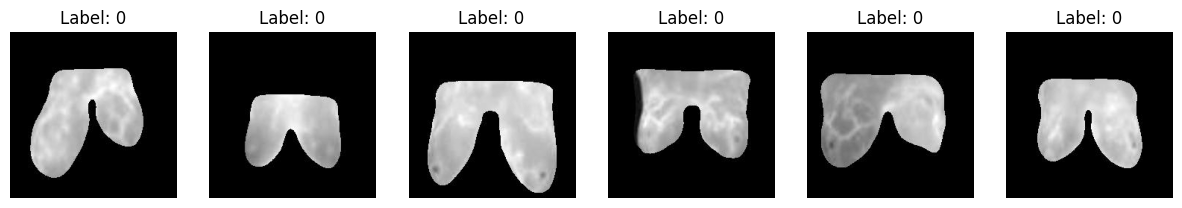

In [108]:
show_samples(train_dataset)

In [131]:
# Import required libraries
import os
import numpy as np
from sklearn.model_selection import train_test_split
import shutil
from IPython.display import display
import pandas as pd

# Paths for your folders
normal_dir = "normal"    # Replace with path to your normal images folder
abnormal_dir = "abnormal"  # Replace with path to your abnormal images folder
output_dir = "output/"      # Replace with where you want the split dataset

# Function to split dataset
def split_separate_folders(normal_dir, abnormal_dir, output_dir, train_ratio=0.7,
                         val_ratio=0.15, test_ratio=0.15, random_state=42):
    """
    Split dataset from separate normal and abnormal folders into train, validation and test sets.
    """
    # Create output directories
    splits = ['train', 'val', 'test']
    classes = ['normal', 'abnormal']

    for split in splits:
        for cls in classes:
            os.makedirs(os.path.join(output_dir, split, cls), exist_ok=True)

    # Dictionary to store results
    results = {
        'Class': [],
        'Training': [],
        'Validation': [],
        'Testing': [],
        'Total': []
    }

    # Process each class
    for cls, src_dir in zip(classes, [normal_dir, abnormal_dir]):
        # Get all images
        images = [f for f in os.listdir(src_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]
        total_images = len(images)

        # First split: separate training set
        train_images, temp_images = train_test_split(
            images,
            train_size=train_ratio,
            random_state=random_state
        )

        # Second split: separate validation and test from the remaining data
        val_ratio_adjusted = val_ratio / (val_ratio + test_ratio)
        val_images, test_images = train_test_split(
            temp_images,
            train_size=val_ratio_adjusted,
            random_state=random_state
        )

        # Copy files to respective directories
        for img, split_type in zip([train_images, val_images, test_images], splits):
            for image_name in img:
                shutil.copy2(
                    os.path.join(src_dir, image_name),
                    os.path.join(output_dir, split_type, cls, image_name)
                )

        # Store results
        results['Class'].append(cls)
        results['Training'].append(len(train_images))
        results['Validation'].append(len(val_images))
        results['Testing'].append(len(test_images))
        results['Total'].append(total_images)

    # Create and display summary DataFrame
    summary_df = pd.DataFrame(results)
    display(summary_df)

    # Display percentages
    print("\nSplit Percentages:")
    for split in ['Training', 'Validation', 'Testing']:
        total = summary_df[split].sum()
        overall_total = summary_df['Total'].sum()
        print(f"{split}: {total} images ({total/overall_total*100:.1f}%)")

    return summary_df

# Run the splitting function
summary = split_separate_folders(
    normal_dir=normal_dir,
    abnormal_dir=abnormal_dir,
    output_dir=output_dir
)


# Verify the splits
for split in ['train', 'val', 'test']:
    for cls in ['normal', 'abnormal']:
        path = os.path.join(output_dir, split, cls)
        num_images = len([f for f in os.listdir(path) if f.endswith(('.png', '.jpg', '.jpeg'))])
        print(f"{split}/{cls}: {num_images} images")

,Class,Training,Validation,Testing,Total
0,normal,350,75,75,500
1,abnormal,350,75,75,500



Split Percentages:
Training: 700 images (70.0%)
Validation: 150 images (15.0%)
Testing: 150 images (15.0%)
train/normal: 350 images
train/abnormal: 350 images
val/normal: 75 images
val/abnormal: 75 images
test/normal: 75 images
test/abnormal: 75 images


In [133]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os
import numpy as np

class MedicalImageDataset(Dataset):
    """Custom Dataset for loading medical images"""
    def __init__(self, data_dir, transform=None):
        """
        Args:
            data_dir (str): Path to the dataset directory
            transform (callable, optional): Optional transform to be applied on images
        """
        self.data_dir = data_dir
        self.transform = transform
        self.classes = ['normal', 'abnormal']
        self.class_to_idx = {cls: idx for idx, cls in enumerate(self.classes)}

        self.images = []
        self.labels = []

        # Load all images and labels
        for cls in self.classes:
            class_dir = os.path.join(data_dir, cls)
            class_idx = self.class_to_idx[cls]

            for img_name in os.listdir(class_dir):
                if img_name.endswith(('.png', '.jpg', '.jpeg')):
                    self.images.append(os.path.join(class_dir, img_name))
                    self.labels.append(class_idx)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        label = self.labels[idx]

        # Load image (grayscale since you mentioned one channel)
        image = Image.open(img_path).convert('L')

        if self.transform:
            image = self.transform(image)

        return image, label

# Set random seed for reproducibility
torch.manual_seed(42)

# Define transforms
# Note: Normalization values are set for grayscale images
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Create datasets
def create_data_loaders(data_dir, batch_size=32, num_workers=4):
    """
    Create train, validation, and test data loaders

    Args:
        data_dir (str): Base directory containing train, val, test folders
        batch_size (int): Batch size for the data loaders
        num_workers (int): Number of workers for data loading

    Returns:
        tuple: (train_loader, val_loader, test_loader)
    """
    # Create datasets
    train_dataset = MedicalImageDataset(
        os.path.join(data_dir, 'train'),
        transform=train_transform
    )

    val_dataset = MedicalImageDataset(
        os.path.join(data_dir, 'val'),
        transform=val_test_transform
    )

    test_dataset = MedicalImageDataset(
        os.path.join(data_dir, 'test'),
        transform=val_test_transform
    )

    # Print dataset sizes
    print(f"Training set size: {len(train_dataset)}")
    print(f"Validation set size: {len(val_dataset)}")
    print(f"Test set size: {len(test_dataset)}")

    # Create data loaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True
    )

    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True
    )

    return train_loader, val_loader, test_loader

# Usage example:
data_dir = "output"  # The output directory from your previous split
batch_size = 32  # Adjust based on your GPU memory

# Create the data loaders
train_loader, val_loader, test_loader = create_data_loaders(
    data_dir=data_dir,
    batch_size=batch_size
)

# Example of how to use the loaders
# Verify data loading and shapes
for images, labels in train_loader:
    print(f"Batch shape: {images.shape}")  # Should be [batch_size, 1, 224, 224]
    print(f"Labels shape: {labels.shape}")  # Should be [batch_size]
    print(f"Labels: {labels}")  # 0 for normal, 1 for abnormal
    break

Training set size: 700
Validation set size: 150
Test set size: 150
Batch shape: torch.Size([32, 1, 224, 224])
Labels shape: torch.Size([32])
Labels: tensor([0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1,
        1, 0, 1, 1, 1, 1, 0, 1])


In [134]:
class ComplexConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0):
        super(ComplexConv2d, self).__init__()
        self.real = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        self.imag = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)

    def forward(self, x):
        real, imag = x[:, 0], x[:, 1]
        real_out = self.real(real) - self.imag(imag)
        imag_out = self.real(imag) + self.imag(real)
        return torch.stack([real_out, imag_out], dim=1)

class ComplexLinear(nn.Module):
    def __init__(self, in_features, out_features):
        super(ComplexLinear, self).__init__()
        self.real = nn.Linear(in_features, out_features)
        self.imag = nn.Linear(in_features, out_features)

    def forward(self, x):
        real, imag = x[:, 0], x[:, 1]
        real_out = self.real(real) - self.imag(imag)
        imag_out = self.real(imag) + self.imag(real)
        return torch.stack([real_out, imag_out], dim=1)

class ComplexActivation(nn.Module):
    def __init__(self, activation_func):
        super(ComplexActivation, self).__init__()
        self.activation_func = activation_func

    def forward(self, x):
        real, imag = x[:, 0], x[:, 1]
        real_out = self.activation_func(real)
        imag_out = self.activation_func(imag)
        return torch.stack([real_out, imag_out], dim=1)

class ComplexMagnitude(nn.Module):
    def forward(self, x):
        real, imag = x[:, 0], x[:, 1]
        return torch.sqrt(real**2 + imag**2)

In [135]:
class ComplexModel(nn.Module):
    def __init__(self):
        super(ComplexModel, self).__init__()

        self.conv1 = ComplexConv2d(1, 8, kernel_size=3, stride=1, padding=1)
        self.conv2 = ComplexConv2d(8, 16, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(2)
        self.activation = ComplexActivation(nn.ReLU())

        self.flattened_size = 16 * 56 * 56
        self.fc1 = ComplexLinear(self.flattened_size, 10)
        self.fc2 = nn.Linear(10, 2)
        self.magnitude = ComplexMagnitude()

    def forward(self, x):
        x = torch.stack([x, torch.zeros_like(x)], dim=1)

        x = self.conv1(x)
        x = self.activation(x)
        x = torch.stack([self.pool(x[:, 0]), self.pool(x[:, 1])], dim=1)
        x = self.conv2(x)
        x = self.activation(x)
        x = torch.stack([self.pool(x[:, 0]), self.pool(x[:, 1])], dim=1)

        x = x.view(x.size(0), 2, -1)
        x = self.fc1(x)
        x = self.magnitude(x)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)



In [118]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ComplexModel().to(device)
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [119]:

n_epochs = 30

for epoch in range(n_epochs):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        if batch_idx % 10 == 0:
            print(f"Epoch {epoch+1}/{n_epochs}, Batch {batch_idx}, Loss: {loss.item():.4f}")

    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for val_data, val_target in val_loader:
            val_data, val_target = val_data.to(device), val_target.to(device)
            val_output = model(val_data)
            val_loss += criterion(val_output, val_target).item()
            _, predicted = torch.max(val_output.data, 1)
            total += val_target.size(0)
            correct += (predicted == val_target).sum().item()

    val_loss /= len(val_loader)
    val_accuracy = correct / total
    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

print("Training complete.")


Epoch 1/30, Batch 0, Loss: 0.7932
Epoch 1/30, Batch 10, Loss: 1.1371
Epoch 1/30, Batch 20, Loss: 0.5480
Epoch 1/30, Batch 30, Loss: 0.4113
Validation Loss: 0.5414, Validation Accuracy: 0.7018
Epoch 2/30, Batch 0, Loss: 0.3618
Epoch 2/30, Batch 10, Loss: 0.3163
Epoch 2/30, Batch 20, Loss: 0.3214
Epoch 2/30, Batch 30, Loss: 0.3328
Validation Loss: 0.1843, Validation Accuracy: 0.9430
Epoch 3/30, Batch 0, Loss: 0.0933
Epoch 3/30, Batch 10, Loss: 0.1792
Epoch 3/30, Batch 20, Loss: 0.1425
Epoch 3/30, Batch 30, Loss: 0.2132
Validation Loss: 0.1726, Validation Accuracy: 0.9430
Epoch 4/30, Batch 0, Loss: 0.1307
Epoch 4/30, Batch 10, Loss: 0.1180
Epoch 4/30, Batch 20, Loss: 0.0866
Epoch 4/30, Batch 30, Loss: 0.0984
Validation Loss: 0.0891, Validation Accuracy: 0.9737
Epoch 5/30, Batch 0, Loss: 0.0281
Epoch 5/30, Batch 10, Loss: 0.0520
Epoch 5/30, Batch 20, Loss: 0.0481
Epoch 5/30, Batch 30, Loss: 0.0610
Validation Loss: 0.0934, Validation Accuracy: 0.9737
Epoch 6/30, Batch 0, Loss: 0.0171
Epoch 

In [121]:
model.eval()
test_loss = 0.0
test_correct = 0
test_total = 0

with torch.no_grad():
    for test_data, test_target in test_loader:
        test_data, test_target = test_data.to(device), test_target.to(device)
        test_output = model(test_data)
        test_loss += criterion(test_output, test_target).item()
        _, test_predicted = torch.max(test_output.data, 1)
        test_total += test_target.size(0)
        test_correct += (test_predicted == test_target).sum().item()

# Calculate average test loss and accuracy
test_loss /= len(test_loader)
test_accuracy = test_correct / test_total

print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Test Loss: 0.0076, Test Accuracy: 0.9956


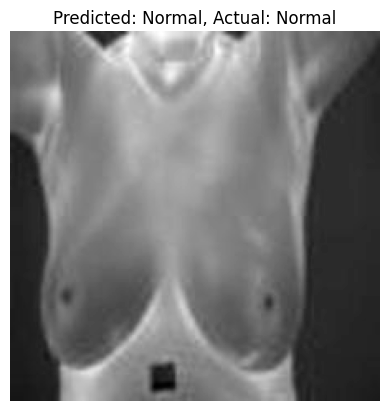

In [123]:
val_dataset_new = MedicalImageDataset(
    os.path.join(data_dir, 'val'),  # data_dir was set to "output"
    transform=val_test_transform
)
test_single_image(model, val_dataset_new, test_index)  # Use the new val_dataset

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import pennylane as qml
from pennylane import numpy as np

# Define the quantum device
n_qubits = 4
dev = qml.device("default.qubit", wires=n_qubits)

def circuit(inputs, weights):
    qml.templates.AngleEmbedding(inputs, wires=range(n_qubits))
    qml.templates.StronglyEntanglingLayers(weights, wires=range(n_qubits))
    return [qml.expval(qml.PauliZ(w)) for w in range(n_qubits)]

class QNNLayer(nn.Module):
    def __init__(self, n_qubits, n_layers):
        super(QNNLayer, self).__init__()
        self.n_qubits = n_qubits
        self.n_layers = n_layers
        self.qnode = qml.QNode(circuit, dev, interface="torch")

        self.weights = nn.Parameter(torch.randn(n_layers, n_qubits, 3))

    def forward(self, x):
        q_out = [self.qnode(sample, self.weights) for sample in x]
        q_out_tensor = torch.tensor(q_out, dtype=torch.float32, device=x.device)
        return q_out_tensor

class QuantumTransferLearningModel(nn.Module):
    def __init__(self):
        super(QuantumTransferLearningModel, self).__init__()

        self.feature_extractor = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Fully connected layer after CNN
        self.fc1 = nn.Linear(256 * 14 * 14, n_qubits)  # Flattened image size (224x224) -> n_qubits

        # Quantum Neural Network layer
        self.qnn = QNNLayer(n_qubits, 2)  # Quantum layer with n_qubits and 2 layers

        # Final fully connected layer for classification
        self.fc2 = nn.Linear(n_qubits, 2)  # Binary classification (normal vs abnormal)

    def forward(self, x):
        x = self.feature_extractor(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.qnn(x)
        x = self.fc2(x)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = QuantumTransferLearningModel().to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.005)

# Training loop
num_epochs = 30
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:  # Assuming you have a DataLoader for training data
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)

        # Compute loss
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_accuracy = correct / total

    # Validation phase
    model.eval()
    val_running_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for val_inputs, val_labels in val_loader:  # Assuming you have a DataLoader for validation data
            val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)

            # Forward pass
            val_outputs = model(val_inputs)

            # Compute loss
            val_loss = criterion(val_outputs, val_labels)

            val_running_loss += val_loss.item()
            _, val_predicted = torch.max(val_outputs.data, 1)
            val_total += val_labels.size(0)
            val_correct += (val_predicted == val_labels).sum().item()

    val_loss_avg = val_running_loss / len(val_loader)
    val_accuracy = val_correct / val_total

    print(f"Epoch {epoch+1}/{num_epochs}, "
          f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, "
          f"Val Loss: {val_loss_avg:.4f}, Val Accuracy: {val_accuracy:.4f}")

    # Testing phase
    model.eval()
    test_running_loss = 0.0
    test_correct = 0
    test_total = 0

    with torch.no_grad():
        for test_inputs, test_labels in test_loader:  # Assuming you have a DataLoader for test data
            test_inputs, test_labels = test_inputs.to(device), test_labels.to(device)

            # Forward pass
            test_outputs = model(test_inputs)

            # Compute loss
            test_loss = criterion(test_outputs, test_labels)

            test_running_loss += test_loss.item()
            _, test_predicted = torch.max(test_outputs.data, 1)
            test_total += test_labels.size(0)
            test_correct += (test_predicted == test_labels).sum().item()

    test_loss_avg = test_running_loss / len(test_loader)
    test_accuracy = test_correct / test_total

    print(f"Test Loss: {test_loss_avg:.4f}, Test Accuracy: {test_accuracy:.4f}")



Epoch 1/30, Train Loss: 0.7490, Train Accuracy: 0.5000, Val Loss: 0.7305, Val Accuracy: 0.5000
Test Loss: 0.7306, Test Accuracy: 0.5000
Epoch 2/30, Train Loss: 0.7013, Train Accuracy: 0.5000, Val Loss: 0.6999, Val Accuracy: 0.5000
Test Loss: 0.6999, Test Accuracy: 0.5000
Epoch 3/30, Train Loss: 0.6929, Train Accuracy: 0.4986, Val Loss: 0.6927, Val Accuracy: 0.5000
Test Loss: 0.6927, Test Accuracy: 0.5000
Epoch 4/30, Train Loss: 0.6934, Train Accuracy: 0.5000, Val Loss: 0.6924, Val Accuracy: 0.5000
Test Loss: 0.6924, Test Accuracy: 0.5000
Epoch 5/30, Train Loss: 0.6935, Train Accuracy: 0.5000, Val Loss: 0.6922, Val Accuracy: 0.5000
Test Loss: 0.6922, Test Accuracy: 0.5000
Epoch 6/30, Train Loss: 0.6933, Train Accuracy: 0.4743, Val Loss: 0.6931, Val Accuracy: 0.5800
Test Loss: 0.6931, Test Accuracy: 0.6200
